1. Modified objective function with the addition of a trace regularization, to force the diagonal elements of W to zero.
2. Changed activation function to softmax with regularization 1/T*||W-s||_F where S is the the dissimilarity matrix as defined in SDHap.
3. Used kernel k-means to determine haplotype memberships.

Successor to Transformers_v8 (using Goemans-Williamson algorithm when determining haplotype memberships)

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import numpy as np
from numpy import random as rn
from scipy.spatial.distance import pdist, squareform
from os import path
from copy import deepcopy
from tqdm import tqdm

import logging
from typing import Any, List, Tuple
from nptyping import NDArray

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import cvxpy as cp
from matplotlib import pyplot as plt
%matplotlib inline

from read_embeddings import save_ckp, load_ckp, MyFilter, \
    ReadAE, SNVMatrixDataset, learn_embed
from ScheduleOptim import ScheduledOptim
from helper import read_hap, read_true_hap, compute_cpr
from kernel_kmeans import KernelKMeans

In [27]:
class CorrTransformer(nn.Module):
    def __init__(self, d_model: int=512, d_qk: int=None):
        super().__init__()
        d_ff = 4*d_model  # Dimension of intermediate feedforward layer
        n_head = 4  # Number of attention heads
        if d_qk is None:
            d_qk = int(d_model//n_head)  # Dim of query and key vectors in last attn layer

        self.d_model = d_model
        self.d_qk = d_qk
        encoderLayer = nn.TransformerEncoderLayer(d_model, n_head, d_ff,
                                                  batch_first=True)
        self.encoder = nn.TransformerEncoder(encoderLayer, num_layers=3)
        self.attn_lastq = nn.Linear(d_model, d_qk)
#         self.attn_lastk = nn.Linear(d_model, d_qk)
#         self.activation = nn.Tanh()
#         self.activation = nn.Softmax(dim=-1)

    def forward(self, x):
        x_enc = self.encoder(x)
        lastq = self.attn_lastq(x_enc)
        Z = F.normalize(lastq, 2, dim=2)
        
        return torch.matmul(Z, Z.transpose(1,2))

#         lastk = self.attn_lastk(x_enc)
#         Z = self.activation(torch.matmul(lastq, lastk.transpose(1,2))
#                             /np.sqrt(self.d_qk))
#         return 0.5*(Z + Z.transpose(1,2))


In [28]:
def det_memhap(SNVdataset: SNVMatrixDataset,
               ae: ReadAE, xformer: CorrTransformer
               ):

    m = len(SNVdataset)
    dataloader_full = DataLoader(SNVdataset, batch_size=m,
                                num_workers=0)
    for i, (data, idx) in enumerate(dataloader_full):
        SNV_onehot = data
        
    ae.eval()  # Set eval flags
    xformer.eval()  
    
    embed, _ = ae(SNV_onehot)  # Read embeddings
    W_full = xformer(embed[None,:]).detach().numpy()  # Converting to numpy
    W_full = W_full[0]  # Removing dummy dimension

    kmeans = KernelKMeans(n_clusters=2, max_iter=1000, tol=1e-3)
    kmeans.fit(W_full)
    return 2*kmeans.labels_ - 1

In [29]:
# get the ACGT statistics of a read matrix
def ACGT_count(submatrix: NDArray[(Any, Any), int]):
    out = np.zeros((submatrix.shape[1], 4))
    for i in range(4):
        out[:, i] = (submatrix == (i + 1)).sum(axis = 0)

    return out 

In [30]:
def origin2hap(SNV_matrix: NDArray[(Any, Any), int], origin: NDArray[int],
              num_hap: int=2) -> NDArray[(Any, Any), int]:    
    """
    SNV_matrix:
        Full read-SNV matrix
    origin: 
        Specifies origin of each read by an int from (0, 1, ..., num_hap-1)
        
    Returns
        matrix of haplotypes (haplotypes x SNPs)
    """
    
    origin_val = np.unique(origin)
    accepted_val = np.arange(num_hap)
    if np.any(np.intersect1d(origin_val, accepted_val) != origin_val):
    	raise ValueError("Invalid origin values passed as argument.")

    hap_matrix = np.zeros((num_hap, SNV_matrix.shape[1]), dtype=int)
    ACGTcount = ACGT_count(SNV_matrix)  # Stats of entire read matrix
    for h in range(num_hap):
        reads_h = SNV_matrix[origin == h]  # Reads attributed to haplotype i
        h_stats = np.zeros((SNV_matrix.shape[1], 4))
        
        if len(reads_h) != 0:
            h_stats = ACGT_count(reads_h) # ACGT statistics of a single nucleotide position
        hap_matrix[h, :] = np.argmax(h_stats, axis = 1) + 1  # Most commonly occuring base at each pos  
        
        uncov_pos = np.where(np.sum(h_stats, axis = 1) == 0)[0]  # Positions uncovered by reads
        for j in range(len(uncov_pos)):  # if not covered, select the most doninant one based on 'ACGTcount'  
            base_max = np.flatnonzero(ACGTcount[uncov_pos[j], :] == np.amax(ACGTcount[uncov_pos[j], :])) + 1
            if len(base_max) == 1:  # Single dominant base
                hap_matrix[h, uncov_pos[j]] == base_max[0]
            else:  # Choose one of the dominant bases at random
                hap_matrix[h, uncov_pos[j]] = np.random.choice(base_max)

    return hap_matrix

In [31]:
def hamming_distance(read, haplo):
    return sum((haplo - read)[read != 0] != 0)

In [32]:
def MEC(SNV_matrix: NDArray[(Any, Any), int],
        hap_matrix: NDArray[(Any, Any), int]) -> float:  # Compute MEC score
    res = 0
    
    for SNV_read in SNV_matrix:
        dis = [hamming_distance(SNV_read, hap) for j, hap in enumerate(hap_matrix)]
        res = res + min(dis)
        
    return res

In [33]:
def readW(SNVdataset: SNVMatrixDataset, 
          ae: ReadAE, xformer: CorrTransformer
         ) -> NDArray[(Any, Any), float]:
    
    m = len(SNVdataset)
    dataloader_full = DataLoader(SNVdataset, batch_size=m,
                                num_workers=0)
    for i, (data, idx) in enumerate(dataloader_full):
        SNV_onehot = data
        
    ae.eval()  # Set eval flags
    xformer.eval()  
    
    embed, _ = ae(SNV_onehot)  # Read embeddings
    W_full = xformer(embed[None,:]).detach().numpy()  # Converting to numpy
    return W_full[0]

In [34]:
def refine(hap_matrix: NDArray[(Any, Any), int],
           SNV_matrix: NDArray[(Any, Any), int],
           verbose=False
          ) -> NDArray[(Any, Any), int]: 
    """
    This function greedily refines the haplotype matrix by iterating through the
    SNPs and flipping the haplotype bases. The flip is accepted (greedily) if it
    improves the MEC score.

    """

    hap_matrix_greedy = deepcopy(hap_matrix)  # Refined solution
    mec_curr = MEC(SNV_matrix, hap_matrix)  # Current MEC

    hap_matrix_new = deepcopy(hap_matrix)
    while True:
        mec_startiter = mec_curr
        for j in range(np.shape(hap_matrix)[1]):
            hap_matrix_new[:,j] = hap_matrix[:,j][::-1]  # Flip base
            mec_new = MEC(SNV_matrix, hap_matrix_new)
            if mec_new < mec_curr:  # Update refined solution
                mec_curr = mec_new
                hap_matrix_greedy[:,j] = hap_matrix[:,j][::-1]
            else:  # Reverse base flip
                hap_matrix_new[:,j] = hap_matrix[:,j]
        if mec_curr == mec_startiter:  # Greedy refinement not improving MEC
            return hap_matrix_greedy
        elif verbose:
            print("MEC improved from %i to %i"%(mec_startiter, mec_curr))

Set up dataloader and hyperparameters.

In [35]:
outhead = 'cov10_hlen150'
# outhead = 'haptest'
# datapath = 'Simulated_data/diploid/cov15/sample1/simu_erro1_K2_cov5'\
#             '_l5000_iter_1_SNV_matrix.txt'
datapath = 'generate_data/' + outhead + '/' + outhead + '_SNV_matrix.txt'

SNVdata = SNVMatrixDataset(datapath)
SNV_matrix = np.loadtxt(datapath, dtype=int)
SNV_matrix = SNV_matrix[np.sum(SNV_matrix != 0, axis=1) > 1]  # Removing uninformative reads
nSNP = SNV_matrix.shape[1] # Number of SNVs
num_read = len(SNVdata)  # Number of reads
batch_size = int(np.ceil(num_read/20))
d_model = 128  # Size of embeddings

dataloader = DataLoader(SNVdata, batch_size=batch_size,
                        shuffle=True, num_workers=0)

Read in ground truth.

In [36]:
# gt_file = "Simulated_data/diploid/cov15/sample1/combined.fa"
# pos_file = "Simulated_data/diploid/cov15/sample1/"\
#             "simu_erro1_K2_cov5_l5000_iter_1_SNV_pos.txt"
gt_file = 'generate_data/' + outhead + '/combined.fa'
pos_file = 'generate_data/' + outhead + '/' + outhead + '_SNV_pos.txt'
true_haplo = read_true_hap(gt_file, pos_file)

Load autoencoder for read embeddings. If the weights aren't stored in savefile, train autoencoder for said embeddings.

In [37]:
savefile="read_AE"
embedAE = learn_embed(SNVdata, num_epoch=100, embed_dim=d_model, savefile=savefile)

# if path.isfile(savefile):
#     embedAE = ReadAE(nSNP, latent_dim=d_model)
#     embed_optimizer = optim.Adam(embedAE.parameters(), lr=1e-2)
#     embedAE, embed_optimizer, _ = load_ckp(savefile, embedAE, embed_optimizer)
# else:
#     embedAE = learn_embed(SNVdata, num_epoch=100, embed_dim=d_model, savefile=savefile)


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:19<00:00,  2.59s/it]


Setting up transformer with hyperparameters and training it.

In [38]:
corr_xformer = CorrTransformer(d_model, d_model//2)  # Transformer
num_epoch = 10000
warmup_steps = 10  # Number of steps to linear increase learning rate

# xform_optimizer = ScheduledOptim(
#     optim.Adam(list(corr_xformer.parameters()) + list(embedAE.parameters()), betas=(0.9, 0.98), eps=1e-09),
#         lr_mul=0.1, d_model=d_model, n_warmup_steps=warmup_steps) # Optimizer with customized schedule
xform_optimizer = optim.AdamW(list(corr_xformer.parameters()) + list(embedAE.parameters()),
                              lr=1e-5)

In [39]:
def xformer_loss(xformer_output: torch.Tensor, origin: torch.Tensor,
                 Ws: torch.Tensor, Wmask: torch.Tensor,
                 lambda_reg: float = 0.1) -> float:
    
    origin_main = origin.type(torch.FloatTensor)
    obj_main = -1*torch.matmul(origin_main, torch.matmul(xformer_output, origin_main))
    
    origin_onehot = F.one_hot(origin + 1)
    pair_mem = torch.matmul(origin_onehot, origin_onehot.transpose(0,1))
#     for j in torch.unique(origin):
#         print(torch.sum(origin==j))
#         pair_mem[origin==j, :][:, origin==j] = 1
#         print(np.nonzero(pair_mem))
#     print(torch.sum(pair_mem))
    obj_cont = torch.sum((1-pair_mem)*xformer_output**2 + pair_mem*torch.clamp(1-xformer_output, min=0)**2)
    
    obj_reg = lambda_reg*torch.linalg.norm(xformer_output*Wmask - Ws)**2 
    obj_sparse = torch.sum(torch.abs(xformer_output))
    
    res = obj_cont + obj_reg + (1e1)*obj_sparse
#     res = obj_sparse
#     print('Clustering loss: %.3f, regularization: %.3f, sparsity: %.3f' %(obj_cont, obj_reg, obj_sparse))
    return res

In [40]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create handlers
c_handler = logging.StreamHandler()
f_handler = logging.FileHandler('xformer_train.log')
c_handler.setLevel(logging.WARNING)
f_handler.setLevel(logging.INFO)
f_handler.addFilter(MyFilter(logging.INFO))

# Create formatters and add it to handlers
c_format = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
f_format = logging.Formatter('%(message)s')
c_handler.setFormatter(c_format)
f_handler.setFormatter(f_format)

# Add handlers to the logger
logger.addHandler(c_handler)
logger.addHandler(f_handler)

In [41]:
xform_train_loss_arr = []
mec = []
cpr = []
xformer_savefile = "corr_xformer"

hap_origin = det_memhap(SNVdata, embedAE, corr_xformer)  # Initial haplotype memberships
print(hap_origin.dtype)
hap_matrix = origin2hap(SNV_matrix, (hap_origin.astype(int) + 1)/2) 
mec.append(MEC(SNV_matrix, hap_matrix))
cpr.append(compute_cpr(hap_matrix, true_haplo))
mec_min = np.inf
cpr_max = 0

num_reads = np.shape(SNV_matrix)[0]
W_sim = np.zeros((num_reads, num_reads))
W_dissim = np.zeros((num_reads, num_reads))
W_mask = np.zeros((num_reads, num_reads), dtype=bool)

# Computing similarity matrix for supervision
for i, read_i in enumerate(tqdm(SNV_matrix)):
    for j, read_j in enumerate(SNV_matrix):
        if np.any((read_i != 0) & (read_j != 0)):  # Only if reads overlap
            W_mask[i, j] = True
            W_sim[i, j] = np.sum((read_i == read_j)[(read_i != 0) | (read_j != 0)])
            W_dissim[i, j] = np.sum((read_i != read_j)[(read_i != 0) | (read_j != 0)])

W_mask = torch.from_numpy(W_mask)
W_sup = torch.from_numpy((W_sim - W_dissim)/(W_sim + W_dissim + 1e-10))

int64


100%|███████████████████████████████████████████████████████████████████████████████| 1548/1548 [00:17<00:00, 88.62it/s]


In [42]:
torch.matmul(F.one_hot(torch.from_numpy((hap_origin+1))),
            F.one_hot(torch.from_numpy((hap_origin+1))).transpose(0,1)
           )[0]
np.unique(hap_origin, return_counts=True)

(array([-1,  1]), array([869, 679]))

In [43]:
for epoch in range(num_epoch):
    xform_train_loss = 0
    embedAE.train()  # Set train flags
    corr_xformer.train()

    for batch_data, batch_idx in dataloader:
        xform_optimizer.zero_grad()
        embed, recon = embedAE(batch_data)
        Z_batch = corr_xformer(embed[None,:])
        
        MSE = nn.MSELoss()
#         AE_loss = MSE(recon, batch_data)  # Reconstruction error
        xform_loss = xformer_loss(Z_batch[0],
                                  torch.from_numpy(hap_origin[batch_idx]),
                                  W_sup[batch_idx][:,batch_idx],
                                  W_mask[batch_idx][:,batch_idx],
                                  lambda_reg=1e2) # + 0.1*AE_loss
        xform_loss.backward()
#         xform_optimizer.step_and_update_lr()
        xform_optimizer.step()
        xform_train_loss += xform_loss.item()
    
    xform_train_loss = xform_train_loss / len(dataloader)
    xform_train_loss_arr.append(xform_train_loss)
    
    hap_origin = det_memhap(SNVdata, embedAE, corr_xformer)  # Initial haplotype memberships
    hap_matrix = origin2hap(SNV_matrix, (hap_origin.astype(int) + 1)/2)
#     hap_matrix = refine(hap_matrix, SNV_matrix)

    mec_curr = MEC(SNV_matrix, hap_matrix)
    if mec_curr < mec_min:
        mec_min = mec_curr
        W_best = readW(SNVdata, embedAE, corr_xformer)
        hap_origin_best = 1*hap_origin
        hap_matrix_best = 1*hap_matrix
        epoch_best = epoch
    cpr_curr = compute_cpr(hap_matrix, true_haplo)
    if cpr_curr > cpr_max:
        cpr_max = cpr_curr
    mec.append(mec_curr)
    cpr.append(cpr_curr)
    
    # Display epoch training loss
    logger.info("epoch : {}/{}, loss = {:.2f}".format(epoch + 1, num_epoch, xform_train_loss))
    print("epoch : {}/{}, loss = {:.2f}".format(epoch + 1, num_epoch, xform_train_loss))
    if xformer_savefile and (epoch % 10 == 0):
        checkpoint = {
        'epoch': epoch + 1,
        'state_dict': embedAE.state_dict(),
#         'optimizer': xform_optimizer.state_dict(),
        }
        save_ckp(checkpoint, xformer_savefile)

epoch : 1/10000, loss = 86009.09
epoch : 2/10000, loss = 50097.16
epoch : 3/10000, loss = 34239.29
epoch : 4/10000, loss = 28807.78
epoch : 5/10000, loss = 23957.60
epoch : 6/10000, loss = 22626.49
epoch : 7/10000, loss = 21923.60
epoch : 8/10000, loss = 21385.58
epoch : 9/10000, loss = 21008.97
epoch : 10/10000, loss = 21315.39
epoch : 11/10000, loss = 21046.84
epoch : 12/10000, loss = 21290.81
epoch : 13/10000, loss = 20342.49
epoch : 14/10000, loss = 20878.84
epoch : 15/10000, loss = 20953.32
epoch : 16/10000, loss = 20767.94
epoch : 17/10000, loss = 20824.47
epoch : 18/10000, loss = 21327.81
epoch : 19/10000, loss = 21281.69
epoch : 20/10000, loss = 20491.02
epoch : 21/10000, loss = 20171.93
epoch : 22/10000, loss = 21258.56
epoch : 23/10000, loss = 21255.05
epoch : 24/10000, loss = 21031.65
epoch : 25/10000, loss = 20606.31
epoch : 26/10000, loss = 20138.67
epoch : 27/10000, loss = 20935.34
epoch : 28/10000, loss = 21009.47
epoch : 29/10000, loss = 20375.62
epoch : 30/10000, loss 

epoch : 239/10000, loss = 20244.61
epoch : 240/10000, loss = 19947.47
epoch : 241/10000, loss = 19471.91
epoch : 242/10000, loss = 19221.69
epoch : 243/10000, loss = 19205.73
epoch : 244/10000, loss = 19647.14
epoch : 245/10000, loss = 19387.49
epoch : 246/10000, loss = 19672.38
epoch : 247/10000, loss = 19543.63
epoch : 248/10000, loss = 18963.93
epoch : 249/10000, loss = 19670.79
epoch : 250/10000, loss = 19401.70
epoch : 251/10000, loss = 19404.08
epoch : 252/10000, loss = 19093.82
epoch : 253/10000, loss = 18923.31
epoch : 254/10000, loss = 19401.55
epoch : 255/10000, loss = 19747.24
epoch : 256/10000, loss = 19258.27
epoch : 257/10000, loss = 19810.26
epoch : 258/10000, loss = 19684.19
epoch : 259/10000, loss = 19537.50
epoch : 260/10000, loss = 19186.64
epoch : 261/10000, loss = 19217.35
epoch : 262/10000, loss = 19247.66
epoch : 263/10000, loss = 19561.66
epoch : 264/10000, loss = 19185.77
epoch : 265/10000, loss = 19184.95
epoch : 266/10000, loss = 19544.17
epoch : 267/10000, l

epoch : 474/10000, loss = 18497.54
epoch : 475/10000, loss = 19115.81
epoch : 476/10000, loss = 18845.46
epoch : 477/10000, loss = 19037.46
epoch : 478/10000, loss = 19767.00
epoch : 479/10000, loss = 19336.64
epoch : 480/10000, loss = 18897.45
epoch : 481/10000, loss = 18806.34
epoch : 482/10000, loss = 18709.52
epoch : 483/10000, loss = 18966.23
epoch : 484/10000, loss = 19131.84
epoch : 485/10000, loss = 19690.64
epoch : 486/10000, loss = 19047.54
epoch : 487/10000, loss = 18969.80
epoch : 488/10000, loss = 19130.25
epoch : 489/10000, loss = 19587.65
epoch : 490/10000, loss = 19358.04
epoch : 491/10000, loss = 19470.28
epoch : 492/10000, loss = 19346.21
epoch : 493/10000, loss = 18640.02
epoch : 494/10000, loss = 19203.84
epoch : 495/10000, loss = 19078.94
epoch : 496/10000, loss = 19288.42
epoch : 497/10000, loss = 19835.35
epoch : 498/10000, loss = 18966.10
epoch : 499/10000, loss = 19240.19
epoch : 500/10000, loss = 19374.15
epoch : 501/10000, loss = 18830.37
epoch : 502/10000, l

epoch : 709/10000, loss = 18676.04
epoch : 710/10000, loss = 18977.46
epoch : 711/10000, loss = 18398.73
epoch : 712/10000, loss = 18901.62
epoch : 713/10000, loss = 18869.83
epoch : 714/10000, loss = 18581.87
epoch : 715/10000, loss = 18630.24
epoch : 716/10000, loss = 18642.48
epoch : 717/10000, loss = 19018.16
epoch : 718/10000, loss = 18767.45
epoch : 719/10000, loss = 18936.60
epoch : 720/10000, loss = 18650.73
epoch : 721/10000, loss = 18406.21
epoch : 722/10000, loss = 19232.30
epoch : 723/10000, loss = 18484.44
epoch : 724/10000, loss = 18211.93
epoch : 725/10000, loss = 18980.28
epoch : 726/10000, loss = 18499.90
epoch : 727/10000, loss = 18614.91
epoch : 728/10000, loss = 18303.00
epoch : 729/10000, loss = 18698.87
epoch : 730/10000, loss = 18809.63
epoch : 731/10000, loss = 18849.50
epoch : 732/10000, loss = 19058.09
epoch : 733/10000, loss = 18585.60
epoch : 734/10000, loss = 18381.32
epoch : 735/10000, loss = 18783.36
epoch : 736/10000, loss = 18646.97
epoch : 737/10000, l

epoch : 944/10000, loss = 18019.02
epoch : 945/10000, loss = 18817.59
epoch : 946/10000, loss = 17765.96
epoch : 947/10000, loss = 18120.78
epoch : 948/10000, loss = 18563.40
epoch : 949/10000, loss = 18420.72
epoch : 950/10000, loss = 18435.52
epoch : 951/10000, loss = 18082.50
epoch : 952/10000, loss = 18410.84
epoch : 953/10000, loss = 17809.82
epoch : 954/10000, loss = 18089.55
epoch : 955/10000, loss = 18304.90
epoch : 956/10000, loss = 18229.31
epoch : 957/10000, loss = 18675.80
epoch : 958/10000, loss = 18341.65
epoch : 959/10000, loss = 18101.46
epoch : 960/10000, loss = 17912.65
epoch : 961/10000, loss = 17884.60
epoch : 962/10000, loss = 18257.40
epoch : 963/10000, loss = 18155.47
epoch : 964/10000, loss = 18185.55
epoch : 965/10000, loss = 17712.33
epoch : 966/10000, loss = 17987.64
epoch : 967/10000, loss = 17650.26
epoch : 968/10000, loss = 17774.75
epoch : 969/10000, loss = 18110.31
epoch : 970/10000, loss = 17643.66
epoch : 971/10000, loss = 18782.89
epoch : 972/10000, l

epoch : 1174/10000, loss = 17618.18
epoch : 1175/10000, loss = 17831.27
epoch : 1176/10000, loss = 18133.09
epoch : 1177/10000, loss = 17784.17
epoch : 1178/10000, loss = 17481.58
epoch : 1179/10000, loss = 17654.08
epoch : 1180/10000, loss = 17438.43
epoch : 1181/10000, loss = 17705.18
epoch : 1182/10000, loss = 17964.64
epoch : 1183/10000, loss = 17309.30
epoch : 1184/10000, loss = 17786.24
epoch : 1185/10000, loss = 17521.10
epoch : 1186/10000, loss = 17520.77
epoch : 1187/10000, loss = 17613.90
epoch : 1188/10000, loss = 17541.50
epoch : 1189/10000, loss = 17343.95
epoch : 1190/10000, loss = 17430.79
epoch : 1191/10000, loss = 17516.21
epoch : 1192/10000, loss = 17976.72
epoch : 1193/10000, loss = 17358.92
epoch : 1194/10000, loss = 17351.53
epoch : 1195/10000, loss = 17652.18
epoch : 1196/10000, loss = 17955.90
epoch : 1197/10000, loss = 17988.16
epoch : 1198/10000, loss = 17564.36
epoch : 1199/10000, loss = 17895.35
epoch : 1200/10000, loss = 17617.59
epoch : 1201/10000, loss = 1

epoch : 1402/10000, loss = 17029.14
epoch : 1403/10000, loss = 16683.61
epoch : 1404/10000, loss = 16721.77
epoch : 1405/10000, loss = 17130.45
epoch : 1406/10000, loss = 16334.70
epoch : 1407/10000, loss = 16627.28
epoch : 1408/10000, loss = 16469.45
epoch : 1409/10000, loss = 16698.09
epoch : 1410/10000, loss = 16930.19
epoch : 1411/10000, loss = 16699.28
epoch : 1412/10000, loss = 16619.66
epoch : 1413/10000, loss = 16748.75
epoch : 1414/10000, loss = 17119.33
epoch : 1415/10000, loss = 16788.39
epoch : 1416/10000, loss = 16954.68
epoch : 1417/10000, loss = 17087.80
epoch : 1418/10000, loss = 16794.56
epoch : 1419/10000, loss = 16592.47
epoch : 1420/10000, loss = 16889.05
epoch : 1421/10000, loss = 16676.94
epoch : 1422/10000, loss = 16899.69
epoch : 1423/10000, loss = 17239.17
epoch : 1424/10000, loss = 16312.45
epoch : 1425/10000, loss = 16772.58
epoch : 1426/10000, loss = 16619.17
epoch : 1427/10000, loss = 16614.07
epoch : 1428/10000, loss = 17403.24
epoch : 1429/10000, loss = 1

epoch : 1630/10000, loss = 15417.58
epoch : 1631/10000, loss = 14502.49
epoch : 1632/10000, loss = 15084.23
epoch : 1633/10000, loss = 14603.17
epoch : 1634/10000, loss = 14154.96
epoch : 1635/10000, loss = 15356.18
epoch : 1636/10000, loss = 14811.22
epoch : 1637/10000, loss = 14366.61
epoch : 1638/10000, loss = 14547.58
epoch : 1639/10000, loss = 14785.60
epoch : 1640/10000, loss = 15072.16
epoch : 1641/10000, loss = 14405.40
epoch : 1642/10000, loss = 14643.92
epoch : 1643/10000, loss = 14506.26
epoch : 1644/10000, loss = 14859.62
epoch : 1645/10000, loss = 14937.49
epoch : 1646/10000, loss = 15126.12
epoch : 1647/10000, loss = 14539.67
epoch : 1648/10000, loss = 15021.02
epoch : 1649/10000, loss = 14735.17
epoch : 1650/10000, loss = 14635.50
epoch : 1651/10000, loss = 15188.19
epoch : 1652/10000, loss = 15124.74
epoch : 1653/10000, loss = 14653.54
epoch : 1654/10000, loss = 14419.49
epoch : 1655/10000, loss = 14870.45
epoch : 1656/10000, loss = 14676.16
epoch : 1657/10000, loss = 1

epoch : 1858/10000, loss = 13462.16
epoch : 1859/10000, loss = 14213.70
epoch : 1860/10000, loss = 14133.51
epoch : 1861/10000, loss = 13979.90
epoch : 1862/10000, loss = 14040.00
epoch : 1863/10000, loss = 14221.22
epoch : 1864/10000, loss = 13419.72
epoch : 1865/10000, loss = 14076.66
epoch : 1866/10000, loss = 14046.27
epoch : 1867/10000, loss = 13781.55
epoch : 1868/10000, loss = 14056.57
epoch : 1869/10000, loss = 13845.93
epoch : 1870/10000, loss = 14210.33
epoch : 1871/10000, loss = 14250.36
epoch : 1872/10000, loss = 13657.98
epoch : 1873/10000, loss = 14005.89
epoch : 1874/10000, loss = 14186.96
epoch : 1875/10000, loss = 13728.82
epoch : 1876/10000, loss = 13995.58
epoch : 1877/10000, loss = 13667.94
epoch : 1878/10000, loss = 13770.57
epoch : 1879/10000, loss = 13631.69
epoch : 1880/10000, loss = 13965.79
epoch : 1881/10000, loss = 13935.18
epoch : 1882/10000, loss = 13447.93
epoch : 1883/10000, loss = 14041.02
epoch : 1884/10000, loss = 13884.87
epoch : 1885/10000, loss = 1

epoch : 2086/10000, loss = 13580.40
epoch : 2087/10000, loss = 13316.08
epoch : 2088/10000, loss = 13296.51
epoch : 2089/10000, loss = 13188.44
epoch : 2090/10000, loss = 13341.00
epoch : 2091/10000, loss = 13159.75
epoch : 2092/10000, loss = 13087.04
epoch : 2093/10000, loss = 13139.00
epoch : 2094/10000, loss = 13555.92
epoch : 2095/10000, loss = 13614.14
epoch : 2096/10000, loss = 13162.53
epoch : 2097/10000, loss = 12777.73
epoch : 2098/10000, loss = 13727.27
epoch : 2099/10000, loss = 13273.37
epoch : 2100/10000, loss = 13270.30
epoch : 2101/10000, loss = 13329.23
epoch : 2102/10000, loss = 13545.39
epoch : 2103/10000, loss = 13216.38
epoch : 2104/10000, loss = 13461.63
epoch : 2105/10000, loss = 13451.88
epoch : 2106/10000, loss = 13655.11
epoch : 2107/10000, loss = 13506.77
epoch : 2108/10000, loss = 13421.55
epoch : 2109/10000, loss = 13202.80
epoch : 2110/10000, loss = 12935.33
epoch : 2111/10000, loss = 13426.31
epoch : 2112/10000, loss = 12999.84
epoch : 2113/10000, loss = 1

epoch : 2314/10000, loss = 12822.55
epoch : 2315/10000, loss = 12797.91
epoch : 2316/10000, loss = 13004.80
epoch : 2317/10000, loss = 13211.76
epoch : 2318/10000, loss = 13047.85
epoch : 2319/10000, loss = 12740.25
epoch : 2320/10000, loss = 13389.30
epoch : 2321/10000, loss = 13001.87
epoch : 2322/10000, loss = 13233.32
epoch : 2323/10000, loss = 13222.37
epoch : 2324/10000, loss = 13101.38
epoch : 2325/10000, loss = 12620.62
epoch : 2326/10000, loss = 12771.56
epoch : 2327/10000, loss = 12832.06
epoch : 2328/10000, loss = 13095.41
epoch : 2329/10000, loss = 13071.20
epoch : 2330/10000, loss = 12971.98
epoch : 2331/10000, loss = 13368.43
epoch : 2332/10000, loss = 12848.54
epoch : 2333/10000, loss = 12816.95
epoch : 2334/10000, loss = 12922.33
epoch : 2335/10000, loss = 13215.07
epoch : 2336/10000, loss = 12792.88
epoch : 2337/10000, loss = 12825.76
epoch : 2338/10000, loss = 12686.30
epoch : 2339/10000, loss = 12600.72
epoch : 2340/10000, loss = 12539.75
epoch : 2341/10000, loss = 1

epoch : 2542/10000, loss = 12790.24
epoch : 2543/10000, loss = 12415.81
epoch : 2544/10000, loss = 13106.51
epoch : 2545/10000, loss = 12903.78
epoch : 2546/10000, loss = 12881.53
epoch : 2547/10000, loss = 12114.63
epoch : 2548/10000, loss = 12823.70
epoch : 2549/10000, loss = 12322.09
epoch : 2550/10000, loss = 12590.99
epoch : 2551/10000, loss = 12811.60
epoch : 2552/10000, loss = 13074.34
epoch : 2553/10000, loss = 12615.94
epoch : 2554/10000, loss = 12908.09
epoch : 2555/10000, loss = 12546.62
epoch : 2556/10000, loss = 12856.09
epoch : 2557/10000, loss = 12887.05
epoch : 2558/10000, loss = 12606.06
epoch : 2559/10000, loss = 13143.74
epoch : 2560/10000, loss = 12262.23
epoch : 2561/10000, loss = 12234.42
epoch : 2562/10000, loss = 12845.23
epoch : 2563/10000, loss = 12791.64
epoch : 2564/10000, loss = 12704.42
epoch : 2565/10000, loss = 12178.92
epoch : 2566/10000, loss = 12596.91
epoch : 2567/10000, loss = 12372.87
epoch : 2568/10000, loss = 12221.13
epoch : 2569/10000, loss = 1

epoch : 2770/10000, loss = 12238.37
epoch : 2771/10000, loss = 12051.02
epoch : 2772/10000, loss = 12327.84
epoch : 2773/10000, loss = 12451.16
epoch : 2774/10000, loss = 12315.48
epoch : 2775/10000, loss = 12301.11
epoch : 2776/10000, loss = 12558.03
epoch : 2777/10000, loss = 12221.92
epoch : 2778/10000, loss = 12374.25
epoch : 2779/10000, loss = 11874.09
epoch : 2780/10000, loss = 12208.74
epoch : 2781/10000, loss = 12214.53
epoch : 2782/10000, loss = 12316.38
epoch : 2783/10000, loss = 12319.68
epoch : 2784/10000, loss = 12056.15
epoch : 2785/10000, loss = 12267.86
epoch : 2786/10000, loss = 12557.23
epoch : 2787/10000, loss = 11914.43
epoch : 2788/10000, loss = 12358.02
epoch : 2789/10000, loss = 12434.39
epoch : 2790/10000, loss = 12548.21
epoch : 2791/10000, loss = 12410.89
epoch : 2792/10000, loss = 12120.32
epoch : 2793/10000, loss = 12296.46
epoch : 2794/10000, loss = 11995.02
epoch : 2795/10000, loss = 12290.51
epoch : 2796/10000, loss = 12332.59
epoch : 2797/10000, loss = 1

epoch : 2998/10000, loss = 12001.10
epoch : 2999/10000, loss = 12199.32
epoch : 3000/10000, loss = 12170.83
epoch : 3001/10000, loss = 12186.26
epoch : 3002/10000, loss = 12199.11
epoch : 3003/10000, loss = 11724.40
epoch : 3004/10000, loss = 11888.43
epoch : 3005/10000, loss = 11996.98
epoch : 3006/10000, loss = 12140.39
epoch : 3007/10000, loss = 12346.70
epoch : 3008/10000, loss = 12028.96
epoch : 3009/10000, loss = 11822.85
epoch : 3010/10000, loss = 12094.36
epoch : 3011/10000, loss = 11702.06
epoch : 3012/10000, loss = 11892.00
epoch : 3013/10000, loss = 11983.48
epoch : 3014/10000, loss = 12021.22
epoch : 3015/10000, loss = 12173.24
epoch : 3016/10000, loss = 11630.45
epoch : 3017/10000, loss = 11813.32
epoch : 3018/10000, loss = 11926.29
epoch : 3019/10000, loss = 11239.50
epoch : 3020/10000, loss = 12009.03
epoch : 3021/10000, loss = 11829.87
epoch : 3022/10000, loss = 11861.57
epoch : 3023/10000, loss = 11718.11
epoch : 3024/10000, loss = 12224.00
epoch : 3025/10000, loss = 1

epoch : 3226/10000, loss = 11441.80
epoch : 3227/10000, loss = 11852.77
epoch : 3228/10000, loss = 11777.56
epoch : 3229/10000, loss = 11755.63
epoch : 3230/10000, loss = 12000.58
epoch : 3231/10000, loss = 11526.36
epoch : 3232/10000, loss = 11709.68
epoch : 3233/10000, loss = 11749.90
epoch : 3234/10000, loss = 11691.46
epoch : 3235/10000, loss = 11533.48
epoch : 3236/10000, loss = 11452.92
epoch : 3237/10000, loss = 12187.70
epoch : 3238/10000, loss = 11379.21
epoch : 3239/10000, loss = 12105.35
epoch : 3240/10000, loss = 11568.50
epoch : 3241/10000, loss = 11815.20
epoch : 3242/10000, loss = 11410.91
epoch : 3243/10000, loss = 11667.08
epoch : 3244/10000, loss = 11625.81
epoch : 3245/10000, loss = 11931.67
epoch : 3246/10000, loss = 11718.57
epoch : 3247/10000, loss = 11875.68
epoch : 3248/10000, loss = 11682.84
epoch : 3249/10000, loss = 12136.31
epoch : 3250/10000, loss = 12114.86
epoch : 3251/10000, loss = 11554.82
epoch : 3252/10000, loss = 11634.04
epoch : 3253/10000, loss = 1

epoch : 3454/10000, loss = 11471.01
epoch : 3455/10000, loss = 11571.64
epoch : 3456/10000, loss = 11499.14
epoch : 3457/10000, loss = 11665.77
epoch : 3458/10000, loss = 11471.13
epoch : 3459/10000, loss = 11097.30
epoch : 3460/10000, loss = 11737.68
epoch : 3461/10000, loss = 11412.82
epoch : 3462/10000, loss = 11493.66
epoch : 3463/10000, loss = 11991.52
epoch : 3464/10000, loss = 11746.35
epoch : 3465/10000, loss = 11460.76
epoch : 3466/10000, loss = 11678.84
epoch : 3467/10000, loss = 11492.69
epoch : 3468/10000, loss = 11464.34
epoch : 3469/10000, loss = 11778.55
epoch : 3470/10000, loss = 11644.22
epoch : 3471/10000, loss = 11710.06
epoch : 3472/10000, loss = 11312.92
epoch : 3473/10000, loss = 11467.32
epoch : 3474/10000, loss = 11649.86
epoch : 3475/10000, loss = 11329.49
epoch : 3476/10000, loss = 11885.17
epoch : 3477/10000, loss = 11730.98
epoch : 3478/10000, loss = 11255.90
epoch : 3479/10000, loss = 11252.31
epoch : 3480/10000, loss = 11833.45
epoch : 3481/10000, loss = 1

epoch : 3682/10000, loss = 11479.94
epoch : 3683/10000, loss = 11103.33
epoch : 3684/10000, loss = 11368.93
epoch : 3685/10000, loss = 11009.05
epoch : 3686/10000, loss = 10934.71
epoch : 3687/10000, loss = 11505.14
epoch : 3688/10000, loss = 11353.72
epoch : 3689/10000, loss = 11752.99
epoch : 3690/10000, loss = 10979.82
epoch : 3691/10000, loss = 11380.81
epoch : 3692/10000, loss = 11359.70
epoch : 3693/10000, loss = 11464.03
epoch : 3694/10000, loss = 11475.57
epoch : 3695/10000, loss = 11086.84
epoch : 3696/10000, loss = 11306.67
epoch : 3697/10000, loss = 11623.55
epoch : 3698/10000, loss = 11514.17
epoch : 3699/10000, loss = 11487.56
epoch : 3700/10000, loss = 11728.91
epoch : 3701/10000, loss = 11658.48
epoch : 3702/10000, loss = 11110.28
epoch : 3703/10000, loss = 11274.89
epoch : 3704/10000, loss = 11419.02
epoch : 3705/10000, loss = 11109.17
epoch : 3706/10000, loss = 11358.34
epoch : 3707/10000, loss = 11546.88
epoch : 3708/10000, loss = 11433.22
epoch : 3709/10000, loss = 1

epoch : 3910/10000, loss = 11351.82
epoch : 3911/10000, loss = 11117.98
epoch : 3912/10000, loss = 11480.37
epoch : 3913/10000, loss = 11205.74
epoch : 3914/10000, loss = 11319.50
epoch : 3915/10000, loss = 11432.05
epoch : 3916/10000, loss = 11141.43
epoch : 3917/10000, loss = 11231.08
epoch : 3918/10000, loss = 11346.23
epoch : 3919/10000, loss = 11148.36
epoch : 3920/10000, loss = 11270.51
epoch : 3921/10000, loss = 11224.51
epoch : 3922/10000, loss = 11068.17
epoch : 3923/10000, loss = 11395.55
epoch : 3924/10000, loss = 11302.49
epoch : 3925/10000, loss = 11104.51
epoch : 3926/10000, loss = 11142.86
epoch : 3927/10000, loss = 11298.91
epoch : 3928/10000, loss = 11453.65
epoch : 3929/10000, loss = 11247.78
epoch : 3930/10000, loss = 10987.16
epoch : 3931/10000, loss = 10944.26
epoch : 3932/10000, loss = 11075.58
epoch : 3933/10000, loss = 11020.64
epoch : 3934/10000, loss = 11213.99
epoch : 3935/10000, loss = 11312.08
epoch : 3936/10000, loss = 11076.48
epoch : 3937/10000, loss = 1

epoch : 4138/10000, loss = 10954.01
epoch : 4139/10000, loss = 11005.82
epoch : 4140/10000, loss = 11168.75
epoch : 4141/10000, loss = 11244.48
epoch : 4142/10000, loss = 11111.84
epoch : 4143/10000, loss = 10972.51
epoch : 4144/10000, loss = 11556.97
epoch : 4145/10000, loss = 11031.73
epoch : 4146/10000, loss = 11081.59
epoch : 4147/10000, loss = 10916.14
epoch : 4148/10000, loss = 11163.24
epoch : 4149/10000, loss = 11238.26
epoch : 4150/10000, loss = 10968.21
epoch : 4151/10000, loss = 11117.02
epoch : 4152/10000, loss = 11001.71
epoch : 4153/10000, loss = 10903.89
epoch : 4154/10000, loss = 11026.99
epoch : 4155/10000, loss = 11364.95
epoch : 4156/10000, loss = 10946.96
epoch : 4157/10000, loss = 11293.84
epoch : 4158/10000, loss = 11047.08
epoch : 4159/10000, loss = 11113.98
epoch : 4160/10000, loss = 11350.44
epoch : 4161/10000, loss = 10921.70
epoch : 4162/10000, loss = 10842.55
epoch : 4163/10000, loss = 11133.34
epoch : 4164/10000, loss = 11081.56
epoch : 4165/10000, loss = 1

epoch : 4366/10000, loss = 10995.80
epoch : 4367/10000, loss = 10651.31
epoch : 4368/10000, loss = 10905.44
epoch : 4369/10000, loss = 11087.32
epoch : 4370/10000, loss = 10802.81
epoch : 4371/10000, loss = 11345.68
epoch : 4372/10000, loss = 10809.44
epoch : 4373/10000, loss = 10586.43
epoch : 4374/10000, loss = 10940.68
epoch : 4375/10000, loss = 10640.26
epoch : 4376/10000, loss = 11083.67
epoch : 4377/10000, loss = 10924.60
epoch : 4378/10000, loss = 11005.77
epoch : 4379/10000, loss = 10760.82
epoch : 4380/10000, loss = 11356.21
epoch : 4381/10000, loss = 10939.06
epoch : 4382/10000, loss = 10831.59
epoch : 4383/10000, loss = 11190.52
epoch : 4384/10000, loss = 10890.53
epoch : 4385/10000, loss = 10907.34
epoch : 4386/10000, loss = 11333.17
epoch : 4387/10000, loss = 11141.29
epoch : 4388/10000, loss = 11063.66
epoch : 4389/10000, loss = 11060.72
epoch : 4390/10000, loss = 10955.56
epoch : 4391/10000, loss = 10960.53
epoch : 4392/10000, loss = 10909.93
epoch : 4393/10000, loss = 1

epoch : 4594/10000, loss = 10805.82
epoch : 4595/10000, loss = 11007.50
epoch : 4596/10000, loss = 11276.67
epoch : 4597/10000, loss = 10937.25
epoch : 4598/10000, loss = 11021.30
epoch : 4599/10000, loss = 10766.95
epoch : 4600/10000, loss = 10842.72
epoch : 4601/10000, loss = 10750.07
epoch : 4602/10000, loss = 10905.42
epoch : 4603/10000, loss = 10919.13
epoch : 4604/10000, loss = 11033.65
epoch : 4605/10000, loss = 10718.57
epoch : 4606/10000, loss = 10735.07
epoch : 4607/10000, loss = 10925.88
epoch : 4608/10000, loss = 11045.40
epoch : 4609/10000, loss = 10843.08
epoch : 4610/10000, loss = 10952.00
epoch : 4611/10000, loss = 10669.90
epoch : 4612/10000, loss = 10620.73
epoch : 4613/10000, loss = 10526.35
epoch : 4614/10000, loss = 10606.11
epoch : 4615/10000, loss = 10948.92
epoch : 4616/10000, loss = 10664.18
epoch : 4617/10000, loss = 10751.22
epoch : 4618/10000, loss = 10536.00
epoch : 4619/10000, loss = 10412.72
epoch : 4620/10000, loss = 11173.79
epoch : 4621/10000, loss = 1

epoch : 4822/10000, loss = 10829.66
epoch : 4823/10000, loss = 11010.19
epoch : 4824/10000, loss = 10853.74
epoch : 4825/10000, loss = 10706.08
epoch : 4826/10000, loss = 11024.98
epoch : 4827/10000, loss = 10299.75
epoch : 4828/10000, loss = 10449.78
epoch : 4829/10000, loss = 10959.12
epoch : 4830/10000, loss = 10806.49
epoch : 4831/10000, loss = 10560.63
epoch : 4832/10000, loss = 10976.84
epoch : 4833/10000, loss = 10565.58
epoch : 4834/10000, loss = 10931.66
epoch : 4835/10000, loss = 10881.38
epoch : 4836/10000, loss = 10698.65
epoch : 4837/10000, loss = 10704.65
epoch : 4838/10000, loss = 10757.14
epoch : 4839/10000, loss = 10683.80
epoch : 4840/10000, loss = 10418.12
epoch : 4841/10000, loss = 10790.50
epoch : 4842/10000, loss = 10546.89
epoch : 4843/10000, loss = 10983.37
epoch : 4844/10000, loss = 10601.87
epoch : 4845/10000, loss = 11019.33
epoch : 4846/10000, loss = 10902.22
epoch : 4847/10000, loss = 11054.31
epoch : 4848/10000, loss = 10842.10
epoch : 4849/10000, loss = 1

epoch : 5050/10000, loss = 10953.29
epoch : 5051/10000, loss = 10695.89
epoch : 5052/10000, loss = 10609.93
epoch : 5053/10000, loss = 10489.56
epoch : 5054/10000, loss = 10467.96
epoch : 5055/10000, loss = 10578.76
epoch : 5056/10000, loss = 11021.25
epoch : 5057/10000, loss = 10512.23
epoch : 5058/10000, loss = 10375.74
epoch : 5059/10000, loss = 10492.12
epoch : 5060/10000, loss = 10961.88
epoch : 5061/10000, loss = 10189.45
epoch : 5062/10000, loss = 10557.51
epoch : 5063/10000, loss = 10847.35
epoch : 5064/10000, loss = 10820.39
epoch : 5065/10000, loss = 10924.97
epoch : 5066/10000, loss = 10676.43
epoch : 5067/10000, loss = 10677.20
epoch : 5068/10000, loss = 10851.81
epoch : 5069/10000, loss = 10621.12
epoch : 5070/10000, loss = 10342.27
epoch : 5071/10000, loss = 10730.38
epoch : 5072/10000, loss = 10455.39
epoch : 5073/10000, loss = 10704.71
epoch : 5074/10000, loss = 10744.41
epoch : 5075/10000, loss = 10675.27
epoch : 5076/10000, loss = 10502.26
epoch : 5077/10000, loss = 1

epoch : 5278/10000, loss = 10476.98
epoch : 5279/10000, loss = 10505.94
epoch : 5280/10000, loss = 10668.33
epoch : 5281/10000, loss = 10664.55
epoch : 5282/10000, loss = 10699.48
epoch : 5283/10000, loss = 10724.66
epoch : 5284/10000, loss = 10872.19
epoch : 5285/10000, loss = 10498.15
epoch : 5286/10000, loss = 10335.70
epoch : 5287/10000, loss = 10540.20
epoch : 5288/10000, loss = 10838.69
epoch : 5289/10000, loss = 10456.28
epoch : 5290/10000, loss = 10753.56
epoch : 5291/10000, loss = 10634.42
epoch : 5292/10000, loss = 10312.91
epoch : 5293/10000, loss = 10445.83
epoch : 5294/10000, loss = 10900.00
epoch : 5295/10000, loss = 10867.60
epoch : 5296/10000, loss = 10531.74
epoch : 5297/10000, loss = 10874.82
epoch : 5298/10000, loss = 10604.81
epoch : 5299/10000, loss = 10758.64
epoch : 5300/10000, loss = 10748.88
epoch : 5301/10000, loss = 10825.25
epoch : 5302/10000, loss = 10673.18
epoch : 5303/10000, loss = 10740.15
epoch : 5304/10000, loss = 10669.42
epoch : 5305/10000, loss = 1

epoch : 5506/10000, loss = 10542.22
epoch : 5507/10000, loss = 10629.22
epoch : 5508/10000, loss = 10636.43
epoch : 5509/10000, loss = 10392.10
epoch : 5510/10000, loss = 10617.38
epoch : 5511/10000, loss = 10789.39
epoch : 5512/10000, loss = 10448.23
epoch : 5513/10000, loss = 10532.71
epoch : 5514/10000, loss = 10485.29
epoch : 5515/10000, loss = 10164.77
epoch : 5516/10000, loss = 10500.56
epoch : 5517/10000, loss = 10566.98
epoch : 5518/10000, loss = 10395.85
epoch : 5519/10000, loss = 10550.42
epoch : 5520/10000, loss = 10802.26
epoch : 5521/10000, loss = 10245.01
epoch : 5522/10000, loss = 10715.24
epoch : 5523/10000, loss = 10576.66
epoch : 5524/10000, loss = 10622.74
epoch : 5525/10000, loss = 10718.70
epoch : 5526/10000, loss = 10521.87
epoch : 5527/10000, loss = 10797.44
epoch : 5528/10000, loss = 10445.13
epoch : 5529/10000, loss = 10752.23
epoch : 5530/10000, loss = 10563.60
epoch : 5531/10000, loss = 10684.56
epoch : 5532/10000, loss = 10477.73
epoch : 5533/10000, loss = 1

epoch : 5734/10000, loss = 10594.45
epoch : 5735/10000, loss = 10425.85
epoch : 5736/10000, loss = 10448.53
epoch : 5737/10000, loss = 10533.50
epoch : 5738/10000, loss = 10592.74
epoch : 5739/10000, loss = 11020.77
epoch : 5740/10000, loss = 10276.37
epoch : 5741/10000, loss = 10908.80
epoch : 5742/10000, loss = 10488.90
epoch : 5743/10000, loss = 10400.73
epoch : 5744/10000, loss = 10555.07
epoch : 5745/10000, loss = 10939.97
epoch : 5746/10000, loss = 10585.01
epoch : 5747/10000, loss = 10468.62
epoch : 5748/10000, loss = 10528.91
epoch : 5749/10000, loss = 10402.95
epoch : 5750/10000, loss = 10594.68
epoch : 5751/10000, loss = 10387.48
epoch : 5752/10000, loss = 10228.80
epoch : 5753/10000, loss = 10727.69
epoch : 5754/10000, loss = 10669.99
epoch : 5755/10000, loss = 10688.78
epoch : 5756/10000, loss = 10681.92
epoch : 5757/10000, loss = 10568.18
epoch : 5758/10000, loss = 10270.80
epoch : 5759/10000, loss = 10377.39
epoch : 5760/10000, loss = 10476.88
epoch : 5761/10000, loss = 1

epoch : 5962/10000, loss = 10548.53
epoch : 5963/10000, loss = 10643.02
epoch : 5964/10000, loss = 10381.00
epoch : 5965/10000, loss = 10791.98
epoch : 5966/10000, loss = 10592.06
epoch : 5967/10000, loss = 10552.51
epoch : 5968/10000, loss = 10495.24
epoch : 5969/10000, loss = 10585.03
epoch : 5970/10000, loss = 10449.61
epoch : 5971/10000, loss = 10273.02
epoch : 5972/10000, loss = 10345.27
epoch : 5973/10000, loss = 10516.18
epoch : 5974/10000, loss = 10688.07
epoch : 5975/10000, loss = 10692.01
epoch : 5976/10000, loss = 10259.82
epoch : 5977/10000, loss = 10276.54
epoch : 5978/10000, loss = 10222.09
epoch : 5979/10000, loss = 10430.01
epoch : 5980/10000, loss = 10374.66
epoch : 5981/10000, loss = 10460.39
epoch : 5982/10000, loss = 10238.80
epoch : 5983/10000, loss = 10334.18
epoch : 5984/10000, loss = 10542.34
epoch : 5985/10000, loss = 10599.13
epoch : 5986/10000, loss = 10272.03
epoch : 5987/10000, loss = 10519.47
epoch : 5988/10000, loss = 10533.83
epoch : 5989/10000, loss = 1

epoch : 6190/10000, loss = 10457.88
epoch : 6191/10000, loss = 10500.55
epoch : 6192/10000, loss = 10733.11
epoch : 6193/10000, loss = 10360.25
epoch : 6194/10000, loss = 10581.73
epoch : 6195/10000, loss = 10325.35
epoch : 6196/10000, loss = 10706.46
epoch : 6197/10000, loss = 10117.14
epoch : 6198/10000, loss = 10330.28
epoch : 6199/10000, loss = 10611.34
epoch : 6200/10000, loss = 10602.23
epoch : 6201/10000, loss = 10422.55
epoch : 6202/10000, loss = 10151.79
epoch : 6203/10000, loss = 10471.95
epoch : 6204/10000, loss = 10452.33
epoch : 6205/10000, loss = 10207.78
epoch : 6206/10000, loss = 9977.25
epoch : 6207/10000, loss = 10584.82
epoch : 6208/10000, loss = 10315.38
epoch : 6209/10000, loss = 10457.61
epoch : 6210/10000, loss = 10590.22
epoch : 6211/10000, loss = 10258.41
epoch : 6212/10000, loss = 10458.85
epoch : 6213/10000, loss = 10484.22
epoch : 6214/10000, loss = 10321.13
epoch : 6215/10000, loss = 10398.62
epoch : 6216/10000, loss = 10399.55
epoch : 6217/10000, loss = 10

epoch : 6418/10000, loss = 10333.55
epoch : 6419/10000, loss = 10574.12
epoch : 6420/10000, loss = 10616.61
epoch : 6421/10000, loss = 10337.13
epoch : 6422/10000, loss = 10291.60
epoch : 6423/10000, loss = 10491.78
epoch : 6424/10000, loss = 10176.42
epoch : 6425/10000, loss = 10185.54
epoch : 6426/10000, loss = 10385.83
epoch : 6427/10000, loss = 10555.54
epoch : 6428/10000, loss = 10374.52
epoch : 6429/10000, loss = 10562.61
epoch : 6430/10000, loss = 10345.10
epoch : 6431/10000, loss = 10321.53
epoch : 6432/10000, loss = 10342.59
epoch : 6433/10000, loss = 10271.03
epoch : 6434/10000, loss = 10555.99
epoch : 6435/10000, loss = 10634.78
epoch : 6436/10000, loss = 10840.11
epoch : 6437/10000, loss = 10125.32
epoch : 6438/10000, loss = 10487.16
epoch : 6439/10000, loss = 10613.15
epoch : 6440/10000, loss = 10470.75
epoch : 6441/10000, loss = 10235.12
epoch : 6442/10000, loss = 10215.13
epoch : 6443/10000, loss = 10289.44
epoch : 6444/10000, loss = 10098.30
epoch : 6445/10000, loss = 1

epoch : 6646/10000, loss = 10091.90
epoch : 6647/10000, loss = 10244.72
epoch : 6648/10000, loss = 10466.69
epoch : 6649/10000, loss = 10038.65
epoch : 6650/10000, loss = 10257.70
epoch : 6651/10000, loss = 10414.95
epoch : 6652/10000, loss = 10344.30
epoch : 6653/10000, loss = 10543.72
epoch : 6654/10000, loss = 10401.15
epoch : 6655/10000, loss = 10173.43
epoch : 6656/10000, loss = 10558.19
epoch : 6657/10000, loss = 10225.58
epoch : 6658/10000, loss = 10317.37
epoch : 6659/10000, loss = 10524.60
epoch : 6660/10000, loss = 10298.29
epoch : 6661/10000, loss = 10196.25
epoch : 6662/10000, loss = 10377.61
epoch : 6663/10000, loss = 10316.27
epoch : 6664/10000, loss = 10220.40
epoch : 6665/10000, loss = 10392.29
epoch : 6666/10000, loss = 10226.80
epoch : 6667/10000, loss = 10561.25
epoch : 6668/10000, loss = 10293.37
epoch : 6669/10000, loss = 10502.11
epoch : 6670/10000, loss = 10188.42
epoch : 6671/10000, loss = 10376.04
epoch : 6672/10000, loss = 10425.54
epoch : 6673/10000, loss = 1

epoch : 6874/10000, loss = 10123.03
epoch : 6875/10000, loss = 10336.16
epoch : 6876/10000, loss = 10368.65
epoch : 6877/10000, loss = 9876.29
epoch : 6878/10000, loss = 10446.83
epoch : 6879/10000, loss = 10488.33
epoch : 6880/10000, loss = 10268.05
epoch : 6881/10000, loss = 10496.46
epoch : 6882/10000, loss = 10739.33
epoch : 6883/10000, loss = 10272.18
epoch : 6884/10000, loss = 10622.82
epoch : 6885/10000, loss = 10164.07
epoch : 6886/10000, loss = 10195.03
epoch : 6887/10000, loss = 10122.50
epoch : 6888/10000, loss = 10499.88
epoch : 6889/10000, loss = 10151.96
epoch : 6890/10000, loss = 10337.72
epoch : 6891/10000, loss = 10175.82
epoch : 6892/10000, loss = 10297.67
epoch : 6893/10000, loss = 9901.89
epoch : 6894/10000, loss = 10451.75
epoch : 6895/10000, loss = 10270.32
epoch : 6896/10000, loss = 10462.86
epoch : 6897/10000, loss = 10460.57
epoch : 6898/10000, loss = 10288.44
epoch : 6899/10000, loss = 10554.27
epoch : 6900/10000, loss = 10207.62
epoch : 6901/10000, loss = 105

epoch : 7102/10000, loss = 10175.53
epoch : 7103/10000, loss = 10168.46
epoch : 7104/10000, loss = 10119.96
epoch : 7105/10000, loss = 10259.40
epoch : 7106/10000, loss = 10447.25
epoch : 7107/10000, loss = 10506.68
epoch : 7108/10000, loss = 10349.72
epoch : 7109/10000, loss = 10230.41
epoch : 7110/10000, loss = 10315.10
epoch : 7111/10000, loss = 10138.99
epoch : 7112/10000, loss = 10194.58
epoch : 7113/10000, loss = 10412.26
epoch : 7114/10000, loss = 10047.67
epoch : 7115/10000, loss = 10114.16
epoch : 7116/10000, loss = 10359.13
epoch : 7117/10000, loss = 10083.59
epoch : 7118/10000, loss = 10190.51
epoch : 7119/10000, loss = 9986.45
epoch : 7120/10000, loss = 10485.06
epoch : 7121/10000, loss = 10388.64
epoch : 7122/10000, loss = 10106.30
epoch : 7123/10000, loss = 10168.23
epoch : 7124/10000, loss = 10342.28
epoch : 7125/10000, loss = 10431.25
epoch : 7126/10000, loss = 10137.65
epoch : 7127/10000, loss = 10405.24
epoch : 7128/10000, loss = 10033.05
epoch : 7129/10000, loss = 10

epoch : 7330/10000, loss = 10689.08
epoch : 7331/10000, loss = 10107.57
epoch : 7332/10000, loss = 10383.71
epoch : 7333/10000, loss = 10078.78
epoch : 7334/10000, loss = 10506.58
epoch : 7335/10000, loss = 10286.76
epoch : 7336/10000, loss = 10175.78
epoch : 7337/10000, loss = 10430.40
epoch : 7338/10000, loss = 10199.05
epoch : 7339/10000, loss = 10122.43
epoch : 7340/10000, loss = 10099.34
epoch : 7341/10000, loss = 10498.23
epoch : 7342/10000, loss = 10214.73
epoch : 7343/10000, loss = 10596.75
epoch : 7344/10000, loss = 10145.70
epoch : 7345/10000, loss = 10338.93
epoch : 7346/10000, loss = 10038.92
epoch : 7347/10000, loss = 10121.15
epoch : 7348/10000, loss = 10051.97
epoch : 7349/10000, loss = 10143.79
epoch : 7350/10000, loss = 10249.58
epoch : 7351/10000, loss = 10243.68
epoch : 7352/10000, loss = 10186.74
epoch : 7353/10000, loss = 10136.42
epoch : 7354/10000, loss = 10041.24
epoch : 7355/10000, loss = 10412.76
epoch : 7356/10000, loss = 10337.14
epoch : 7357/10000, loss = 1

epoch : 7558/10000, loss = 10352.34
epoch : 7559/10000, loss = 10342.63
epoch : 7560/10000, loss = 10470.38
epoch : 7561/10000, loss = 10216.35
epoch : 7562/10000, loss = 10445.04
epoch : 7563/10000, loss = 10150.00
epoch : 7564/10000, loss = 10327.85
epoch : 7565/10000, loss = 10292.83
epoch : 7566/10000, loss = 10046.73
epoch : 7567/10000, loss = 10629.39
epoch : 7568/10000, loss = 10115.47
epoch : 7569/10000, loss = 10214.43
epoch : 7570/10000, loss = 10110.20
epoch : 7571/10000, loss = 10113.15
epoch : 7572/10000, loss = 10862.72
epoch : 7573/10000, loss = 10129.06
epoch : 7574/10000, loss = 10108.57
epoch : 7575/10000, loss = 10041.39
epoch : 7576/10000, loss = 10377.70
epoch : 7577/10000, loss = 10312.20
epoch : 7578/10000, loss = 10360.30
epoch : 7579/10000, loss = 10079.59
epoch : 7580/10000, loss = 10069.56
epoch : 7581/10000, loss = 10137.91
epoch : 7582/10000, loss = 10418.51
epoch : 7583/10000, loss = 10778.18
epoch : 7584/10000, loss = 10143.87
epoch : 7585/10000, loss = 1

epoch : 7787/10000, loss = 10495.47
epoch : 7788/10000, loss = 10239.72
epoch : 7789/10000, loss = 10101.03
epoch : 7790/10000, loss = 10497.50
epoch : 7791/10000, loss = 10075.03
epoch : 7792/10000, loss = 10081.85
epoch : 7793/10000, loss = 9950.00
epoch : 7794/10000, loss = 10167.74
epoch : 7795/10000, loss = 10123.83
epoch : 7796/10000, loss = 10275.21
epoch : 7797/10000, loss = 10333.73
epoch : 7798/10000, loss = 10131.68
epoch : 7799/10000, loss = 10356.09
epoch : 7800/10000, loss = 9964.14
epoch : 7801/10000, loss = 10467.40
epoch : 7802/10000, loss = 10302.84
epoch : 7803/10000, loss = 10121.64
epoch : 7804/10000, loss = 9977.14
epoch : 7805/10000, loss = 10179.65
epoch : 7806/10000, loss = 9933.24
epoch : 7807/10000, loss = 10189.12
epoch : 7808/10000, loss = 10394.72
epoch : 7809/10000, loss = 10305.90
epoch : 7810/10000, loss = 10243.90
epoch : 7811/10000, loss = 10214.91
epoch : 7812/10000, loss = 10321.46
epoch : 7813/10000, loss = 10141.10
epoch : 7814/10000, loss = 10239

epoch : 8016/10000, loss = 10073.36
epoch : 8017/10000, loss = 9986.81
epoch : 8018/10000, loss = 10156.78
epoch : 8019/10000, loss = 10410.80
epoch : 8020/10000, loss = 9983.97
epoch : 8021/10000, loss = 10108.13
epoch : 8022/10000, loss = 10069.60
epoch : 8023/10000, loss = 10164.00
epoch : 8024/10000, loss = 10161.03
epoch : 8025/10000, loss = 10000.59
epoch : 8026/10000, loss = 10133.26
epoch : 8027/10000, loss = 9927.65
epoch : 8028/10000, loss = 10163.65
epoch : 8029/10000, loss = 10053.74
epoch : 8030/10000, loss = 10338.36
epoch : 8031/10000, loss = 10116.84
epoch : 8032/10000, loss = 10355.02
epoch : 8033/10000, loss = 10225.78
epoch : 8034/10000, loss = 9948.06
epoch : 8035/10000, loss = 10352.51
epoch : 8036/10000, loss = 10272.66
epoch : 8037/10000, loss = 10017.03
epoch : 8038/10000, loss = 10185.59
epoch : 8039/10000, loss = 10300.31
epoch : 8040/10000, loss = 10242.87
epoch : 8041/10000, loss = 10458.37
epoch : 8042/10000, loss = 10294.13
epoch : 8043/10000, loss = 9912.

epoch : 8245/10000, loss = 10290.60
epoch : 8246/10000, loss = 10031.35
epoch : 8247/10000, loss = 9766.43
epoch : 8248/10000, loss = 9893.48
epoch : 8249/10000, loss = 10030.03
epoch : 8250/10000, loss = 9997.38
epoch : 8251/10000, loss = 10365.81
epoch : 8252/10000, loss = 10183.97
epoch : 8253/10000, loss = 10086.39
epoch : 8254/10000, loss = 10165.88
epoch : 8255/10000, loss = 10316.18
epoch : 8256/10000, loss = 10321.15
epoch : 8257/10000, loss = 9961.63
epoch : 8258/10000, loss = 9886.61
epoch : 8259/10000, loss = 10118.59
epoch : 8260/10000, loss = 10183.56
epoch : 8261/10000, loss = 10432.80
epoch : 8262/10000, loss = 10152.71
epoch : 8263/10000, loss = 10021.13
epoch : 8264/10000, loss = 9997.90
epoch : 8265/10000, loss = 10113.63
epoch : 8266/10000, loss = 10179.36
epoch : 8267/10000, loss = 9669.20
epoch : 8268/10000, loss = 9934.17
epoch : 8269/10000, loss = 10289.10
epoch : 8270/10000, loss = 10490.23
epoch : 8271/10000, loss = 10138.31
epoch : 8272/10000, loss = 9998.47
e

epoch : 8474/10000, loss = 10411.20
epoch : 8475/10000, loss = 10143.83
epoch : 8476/10000, loss = 10025.01
epoch : 8477/10000, loss = 9936.61
epoch : 8478/10000, loss = 10339.02
epoch : 8479/10000, loss = 10109.81
epoch : 8480/10000, loss = 10387.99
epoch : 8481/10000, loss = 9982.37
epoch : 8482/10000, loss = 10255.02
epoch : 8483/10000, loss = 10128.11
epoch : 8484/10000, loss = 10267.98
epoch : 8485/10000, loss = 10212.90
epoch : 8486/10000, loss = 9797.98
epoch : 8487/10000, loss = 10224.65
epoch : 8488/10000, loss = 9799.97
epoch : 8489/10000, loss = 9895.72
epoch : 8490/10000, loss = 10416.79
epoch : 8491/10000, loss = 10109.24
epoch : 8492/10000, loss = 10160.92
epoch : 8493/10000, loss = 10021.37
epoch : 8494/10000, loss = 10090.67
epoch : 8495/10000, loss = 10314.21
epoch : 8496/10000, loss = 10052.72
epoch : 8497/10000, loss = 9835.47
epoch : 8498/10000, loss = 10299.36
epoch : 8499/10000, loss = 10190.42
epoch : 8500/10000, loss = 10147.32
epoch : 8501/10000, loss = 10199.2

epoch : 8703/10000, loss = 10141.92
epoch : 8704/10000, loss = 10183.22
epoch : 8705/10000, loss = 9998.31
epoch : 8706/10000, loss = 9962.37
epoch : 8707/10000, loss = 10123.14
epoch : 8708/10000, loss = 10250.77
epoch : 8709/10000, loss = 10072.69
epoch : 8710/10000, loss = 10230.62
epoch : 8711/10000, loss = 10366.23
epoch : 8712/10000, loss = 9940.63
epoch : 8713/10000, loss = 10284.56
epoch : 8714/10000, loss = 10259.14
epoch : 8715/10000, loss = 10133.98
epoch : 8716/10000, loss = 9966.36
epoch : 8717/10000, loss = 9914.93
epoch : 8718/10000, loss = 9980.19
epoch : 8719/10000, loss = 10219.42
epoch : 8720/10000, loss = 9989.70
epoch : 8721/10000, loss = 10126.82
epoch : 8722/10000, loss = 10560.36
epoch : 8723/10000, loss = 10219.12
epoch : 8724/10000, loss = 10034.91
epoch : 8725/10000, loss = 10297.89
epoch : 8726/10000, loss = 10077.70
epoch : 8727/10000, loss = 10199.33
epoch : 8728/10000, loss = 9830.61
epoch : 8729/10000, loss = 10155.38
epoch : 8730/10000, loss = 9937.24
e

epoch : 8933/10000, loss = 10213.05
epoch : 8934/10000, loss = 9923.90
epoch : 8935/10000, loss = 10241.97
epoch : 8936/10000, loss = 10188.29
epoch : 8937/10000, loss = 10025.83
epoch : 8938/10000, loss = 10069.12
epoch : 8939/10000, loss = 10205.86
epoch : 8940/10000, loss = 9920.18
epoch : 8941/10000, loss = 9821.76
epoch : 8942/10000, loss = 10145.19
epoch : 8943/10000, loss = 10351.27
epoch : 8944/10000, loss = 10112.96
epoch : 8945/10000, loss = 9823.80
epoch : 8946/10000, loss = 10305.52
epoch : 8947/10000, loss = 9738.69
epoch : 8948/10000, loss = 10249.74
epoch : 8949/10000, loss = 10074.36
epoch : 8950/10000, loss = 10055.24
epoch : 8951/10000, loss = 9981.35
epoch : 8952/10000, loss = 10326.25
epoch : 8953/10000, loss = 10118.50
epoch : 8954/10000, loss = 10133.08
epoch : 8955/10000, loss = 10433.14
epoch : 8956/10000, loss = 10035.24
epoch : 8957/10000, loss = 10301.58
epoch : 8958/10000, loss = 10045.94
epoch : 8959/10000, loss = 10041.35
epoch : 8960/10000, loss = 9982.93

KeyboardInterrupt: 

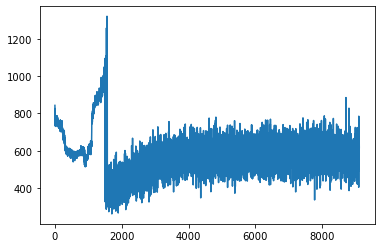

In [44]:
plt.plot(mec)

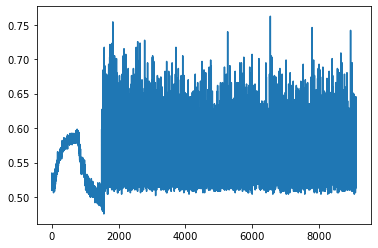

In [45]:
plt.plot(cpr)

[[ 1.         -0.35932271]
 [-0.35932271  1.        ]]
[(261, 0.639344262295082), (266, 0.6311475409836065), (273, 0.5491803278688525)]


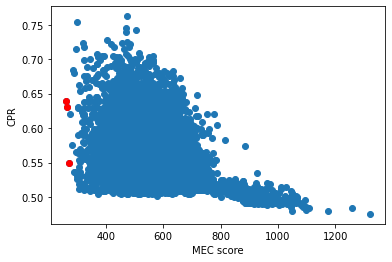

In [46]:
plt.scatter(mec, cpr)
plt.xlabel('MEC score')
plt.ylabel('CPR')

idx_best = np.argsort(mec)[:3]
plt.scatter(np.array(mec)[idx_best], np.array(cpr)[idx_best], color='red')

print(np.corrcoef(mec, cpr))
print(list(zip(np.array(mec)[idx_best], np.array(cpr)[idx_best])))

Text(0.5, 0, 'SNP')

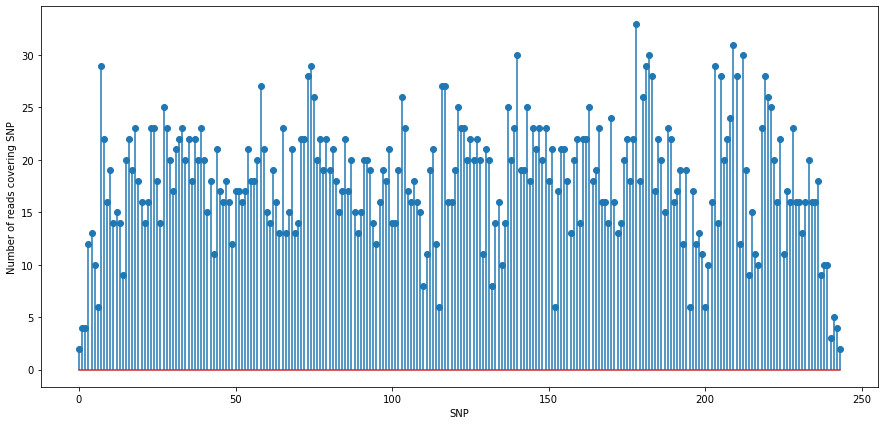

In [47]:
plt.figure(figsize=(15,7))
plt.stem(np.sum(SNV_matrix > 0, axis=0))
plt.ylabel('Number of reads covering SNP')
plt.xlabel('SNP')

In [62]:
np.savez('haptest_xformer_res', rec_hap=hap_matrix_best, rec_hap_origin=hap_origin_best, true_hap=true_haplo)
np.savez('haptest_sdhap_res', rec_hap=hap_matrix_sdhap, rec_hap_origin=hap_origin_sdhap, true_hap=true_haplo)
np.savez('haptest_SNV_matrix', SNV_matrix=SNV_matrix)

### Examining learned W

In [133]:
m = len(SNVdata)
dataloader_full = DataLoader(SNVdata, batch_size=m,
                            num_workers=0)
for i, (data, idx) in enumerate(dataloader_full):
    SNV_onehot = data
SNV_onehot.shape

torch.Size([330, 1, 4, 266])

In [134]:
SNV_sim_tensor = torch.squeeze(torch.tensordot(SNV_onehot, SNV_onehot, dims=[[2,3], [2,3]]))

In [135]:
SNV_sim_tensor[1]

tensor([ 0., 18.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  6.,  0.,
         0.,  0.,  3.,  0.,  0., 14.,  0.,  0.,  0.,  0.,  7.,  0.,  0., 10.,
         0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14.,  0.,  0.,
         0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,
         0., 15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  6., 13.,
         0.,  0.,  3.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [136]:
i = 1
overlap_idx = torch.nonzero(SNV_sim_tensor[i])
print('Overlapping reads: ', torch.squeeze(overlap_idx))
print('SNPs covered by read ', i, ' :', np.nonzero(SNV_matrix[i]))

for idx in torch.squeeze(overlap_idx):
    print('SNPs covered by read ', idx, ' :', np.nonzero(SNV_matrix[idx]), ' giving overlap of ', SNV_sim_tensor[i, idx])

print((W_sup[i]).numpy()[overlap_idx[:,0]])
print(W_sim[i][overlap_idx[:,0]])
print(W_dissim[i][overlap_idx[:,0]])

print(*zip(W_sim[i][overlap_idx[:,0]],
           W_dissim[i][overlap_idx[:,0]],
           W_sup[i].numpy()[overlap_idx[:,0]]))


Overlapping reads:  tensor([  1,   4,  11,  22,  26,  30,  33,  38,  41,  43,  53,  60,  72,  76,
         89, 107, 113, 137, 138, 139, 142, 146, 161])
SNPs covered by read  1  : (array([225, 226, 227, 228, 229, 230, 231, 232, 233, 246, 247, 248, 249,
       250, 251, 252, 253, 254]),)
SNPs covered by read  tensor(1)  : (array([225, 226, 227, 228, 229, 230, 231, 232, 233, 246, 247, 248, 249,
       250, 251, 252, 253, 254]),)  giving overlap of  tensor(18.)
SNPs covered by read  tensor(4)  : (array([209, 210, 211, 212, 213, 214, 215, 216, 233, 234, 235, 236, 237]),)  giving overlap of  tensor(1.)
SNPs covered by read  tensor(11)  : (array([205, 206, 207, 208, 209, 210, 211, 227, 228, 229, 230, 231, 232,
       233, 234]),)  giving overlap of  tensor(7.)
SNPs covered by read  tensor(22)  : (array([219, 220, 221, 222, 223, 225, 226, 227, 238, 239, 240, 241, 242,
       243, 244, 245, 246, 247, 248, 249]),)  giving overlap of  tensor(7.)
SNPs covered by read  tensor(26)  : (array([199, 20

In [137]:
W_full = 1*W_best

print('Max diagonal value: ', np.amax(np.diag(W_full)))
# print('Diagonal values: ', np.diag(W_full))
print('Mean W: ', np.mean(W_full), 'SD of W: ', np.std(W_full))
print('Deviation from mean: ', W_full - np.mean(W_full))
print(W_full[1, overlap_idx[:,0]])

print(W_full[1])

Max diagonal value:  1.0000005
Mean W:  0.66724575 SD of W:  0.28886604
Deviation from mean:  [[ 0.33275408  0.23445189  0.29901427 ...  0.10534036 -0.02166635
   0.18183225]
 [ 0.23445189  0.33275402  0.24084741 ...  0.04742092 -0.04414958
   0.22614765]
 [ 0.29901427  0.24084741  0.33275437 ...  0.22057807  0.12393302
   0.21941686]
 ...
 [ 0.10534036  0.04742092  0.22057807 ...  0.33275408  0.29942667
   0.09647501]
 [-0.02166635 -0.04414958  0.12393302 ...  0.29942667  0.33275408
   0.04315507]
 [ 0.18183225  0.22614765  0.21941686 ...  0.09647501  0.04315507
   0.33275425]]
[0.99999976 0.71429384 0.7707462  0.9371157  0.7057015  0.69046
 0.93750834 0.71048445 0.96893936 0.89868146 0.94941884 0.92373157
 0.7881723  0.6177925  0.8821097  0.8702666  0.93750834 0.72704375
 0.8702666  0.85872734 0.8975475  0.9111577  0.61829984]
[0.90169764 0.99999976 0.90809315 0.77097315 0.71429384 0.6579981
 0.91413337 0.71576005 0.8373474  0.7029186  0.82511795 0.7707462
 0.8915691  0.75131667 0.58

In [138]:
print(torch.nonzero(W_mask[0]).numpy().flatten())
print((W_full - W_sup.numpy())[0])
print((W_full - W_sup.numpy())[0, torch.nonzero(W_mask[0]).numpy().flatten()])

[  0   6   7   9  13  16  29  35  44  55  65  75  86  87  88  90  91  94
  97  98  99 100 104 106 108 117 121 125 128 136 145 151 154 155 156 160
 162 166 168 172 173 183 190 197 201 207 209 210 218 220 231 233 248 249
 257 259 262 265 269 286 288 292 301 303 307 309 310 311 316 318 320 329]
[-1.78807684e-07  9.01697636e-01  9.66260016e-01  7.86364794e-01
  7.22129226e-01  6.42869473e-01  1.59078816e+00  1.59686621e+00
  8.99414003e-01  1.53406684e+00  8.71523619e-01  8.53557587e-01
  9.52323854e-01  1.52024279e+00  4.71186846e-01  4.08056021e-01
  1.58612381e+00  8.71894479e-01  9.27503288e-01  6.87424004e-01
  8.14041197e-01  6.40384436e-01  8.52657318e-01  7.21029639e-01
  4.93678421e-01  7.79380381e-01  7.18269348e-01  8.03967655e-01
  4.79975522e-01  1.30286215e+00  7.40467370e-01  4.30161059e-01
  7.29969144e-01  8.46575737e-01  7.07741439e-01  1.15579448e+00
  9.09089625e-01  9.70199227e-01  7.34244287e-01  6.72417879e-01
  8.61390293e-01  8.89305532e-01  8.88758242e-01  9.61728

In [139]:
print('Fraction of reads assigned to hap1: ', np.sum(hap_origin_best == 1)/len(hap_origin_best))

Fraction of reads assigned to hap1:  0.3575757575757576


In [140]:
W_end = readW(SNVdata, embedAE, corr_xformer)
print(W_end)
print('Mean W: ', np.mean(W_end), 'SD of W: ', np.std(W_end))

[[0.99999976 0.7568522  0.9751339  ... 0.82313216 0.8243951  0.775593  ]
 [0.7568522  0.9999998  0.7756524  ... 0.42893454 0.51898557 0.88306916]
 [0.9751339  0.7756524  0.99999994 ... 0.8525974  0.8602465  0.77887225]
 ...
 [0.82313216 0.42893454 0.8525974  ... 0.9999999  0.9602317  0.4810633 ]
 [0.8243951  0.51898557 0.8602465  ... 0.9602317  1.0000001  0.57770044]
 [0.775593   0.88306916 0.77887225 ... 0.4810633  0.57770044 0.99999994]]
Mean W:  0.599523 SD of W:  0.32721633


### CAECSeq

In [116]:
SNV_matrix = np.loadtxt(datapath, dtype=int)
caec_hap_file = 'generate_data/' + outhead + '/' + outhead + '_Reconstructed_Strains.txt'

caec_haplo = read_hap(caec_hap_file)
cpr_caec = compute_cpr(caec_haplo, true_haplo)

print('CPR for CAECSeq: ', cpr_caec)
print('MEC score for CAECSeq: ', MEC(SNV_matrix, caec_haplo))
print('MEC score for CAECSeq: ', MEC(SNV_matrix[np.sum(SNV_matrix!=0, axis=1) > 1], caec_haplo))

CPR for CAECSeq:  0.665983606557377
MEC score for CAECSeq:  204
MEC score for CAECSeq:  203


In [119]:
SNV_matrix[np.sum(SNV_matrix!=0, axis=1) > 1].shape
SNV_matrix.shape

(1930, 244)

### SDHap

In [25]:
def hap_blocks(SNV_matrix: NDArray[(Any, Any), int]) -> List[List[int]]:
    """
    Parameters
    ----------
    SNV_matrix: NDAray[(Any, Any), int]:
        2D read-SNP matrix
    
    Returns
    -------
    List[List[int]]:
        List of haplotype blocks, where each block is represented by a list of SNP positions comprising
        that block
    """

from collections import deque
# FInding haplotype blocks
SNP_idx = np.zeros(np.shape(SNV_matrix)[1], dtype=bool)  # Tracking SNP positions visited in BFS
SNP_visited = np.zeros(np.shape(SNV_matrix)[1], dtype=bool)  # Tracking SNP positions in queue
print('Number of SNP positions: ', len(SNP_idx))
blocks = []
while not np.all(SNP_idx):
    idx_q = deque([np.flatnonzero(~SNP_idx)[0]])
    SNP_visited[np.flatnonzero(~SNP_idx)[0]] = True
    block_curr = []
    while idx_q:
        idx = idx_q.popleft()
        block_curr.append(idx)
        SNP_idx[idx] = True
#         print('Covered index: ', idx)
        connected_reads = np.flatnonzero(np.sum(SNV_matrix, axis=0))
        connected_reads = connected_reads[~SNP_visited]  # Only look at thus far unvisted SNPs
        idx_q.extend(connected_reads)
        SNP_visited[connected_reads] = True

    blocks.append(block_curr)
print(blocks)

Number of SNP positions:  142
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141]]


In [26]:
read_i = SNV_matrix[0]
read_j = SNV_matrix[0]

np.sum((read_i == read_i)[(read_i != 0) & (read_j != 0)])
print(SNV_matrix.shape)
print(np.unique(np.sum(SNV_matrix!=0, axis=1), return_counts=True))
SNV_matrix = SNV_matrix[np.sum(SNV_matrix!=0, axis=1) > 1]
SNV_matrix.shape

(1626, 142)
(array([ 1,  2,  3,  4,  5,  6,  9, 11]), array([874, 539, 184,  11,  11,   2,   4,   1]))


(752, 142)

In [27]:
# W = squareform(pdist(SNV_matrix, hamming_distance))
# m = np.shape(W)[0]

num_reads = np.shape(SNV_matrix)[0]
W_sim = np.zeros((num_reads, num_reads))
W_dissim = np.zeros((num_reads, num_reads))

for i, read_i in enumerate(tqdm(SNV_matrix)):
    for j, read_j in enumerate(SNV_matrix):
        if np.any((read_i != 0) & (read_j != 0)):  # Only if reads overlap
            W_sim[i, j] = np.sum((read_i == read_j)[(read_i != 0) | (read_j != 0)])
            W_dissim[i, j] = np.sum((read_i != read_j)[(read_i != 0) | (read_j != 0)])

100%|████████████████████████████████████████████████████████████████████████████████| 752/752 [00:04<00:00, 177.08it/s]


In [28]:
W_sdhap = (W_sim - W_dissim)/(W_sim + W_dissim + 1e-10)
print('Fraction of W that is zero: ', np.sum(W_sdhap == 0)/np.size(W_sdhap))

Fraction of W that is zero:  0.9660939622000906


In [29]:
def sdhap(W_sdhap: NDArray[(Any, Any), float]) -> Tuple[NDArray[int],
                                                        NDArray[(Any, Any), int]]:
    sval_thr = 1e-1  # eps_th in SDHap
    change_thr = 1e-5  # eps_tol in SDHap
    m = np.shape(W_sdhap)[0]
    V = np.random.randn(m, 2)
    V = V/np.linalg.norm(V, axis=1).reshape(m,1)  # Row normalization

    col_V = np.shape(V)[1]
    rank_V = 1
    upd = True  # Set to false when convergence is achieved
    obj_curr = np.inf

    while upd:
        for i in range(m):
            V[i] = W_sdhap[i] @ V
            V[i] = V[i]/np.linalg.norm(V[i])

        rank_V = np.sum(np.linalg.svd(V, compute_uv=False) >= sval_thr)
        if(rank_V == col_V):  # V is full column rank
            col_V = col_V + 1
            rand_col = np.random.rand(m) - 0.5
            V = np.append(V, 0.01*rand_col[:,np.newaxis],
                          axis=1)
            V = V/np.linalg.norm(V, axis=1).reshape(m,1)  # Row normalization

        obj_prev = obj_curr
        obj_curr = np.trace(W_sdhap @ V @ V.T)

        upd = (rank_V != col_V) and (np.abs(1.-obj_curr/obj_prev) >= change_thr)

    # Randomized projection
    num_rounds = 10*int(np.ceil(np.log2(m)))  # number of rounds
    round_x = np.zeros((m, num_rounds), dtype=np.float32)  # x for each round
    round_obj = np.zeros(num_rounds)  # ojective for each round
    for i in range(num_rounds):
        unit_vec = np.random.randn(col_V)
    #         unit_vec = unit_vec/np.linalg.norm(unit_vec)
    #     print(i, unit_vec, np.sum(V @ unit_vec > 0))
        x = -1*np.ones(m, dtype=np.float32)
        x[np.where(V @ unit_vec > 0)] = 1

        round_x[:, i] = x
        round_obj[i] = np.dot(x, W_sdhap @ x)

    hap_origin_sdhap = round_x[:, np.argmax(round_obj)]
    hap_matrix_sdhap = origin2hap(SNV_matrix, (hap_origin_sdhap.astype(int) + 1)/2) 
    
    return hap_origin_sdhap, hap_matrix_sdhap

In [30]:
num_runs_sdhap = 100
cpr_arr_sdhap = np.zeros(num_runs_sdhap)
mec_arr_sdhap = np.zeros(num_runs_sdhap)

for i in tqdm(range(num_runs_sdhap)):
    hap_origin_sdhap, hap_matrix_sdhap = sdhap(W_sdhap)
    mec_arr_sdhap[i] = MEC(SNV_matrix, hap_matrix_sdhap)
    cpr_arr_sdhap[i] = compute_cpr(hap_matrix_sdhap, true_haplo)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.79it/s]


[(31.0, 0.6866197183098591), (33.0, 0.7464788732394366), (35.0, 0.6091549295774648)]


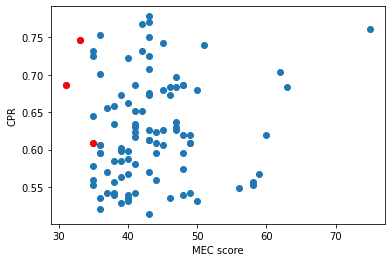

In [31]:
plt.scatter(mec_arr_sdhap, cpr_arr_sdhap)
plt.xlabel('MEC score')
plt.ylabel('CPR')

idx_sdhap = np.argsort(mec_arr_sdhap)[:3]
plt.scatter(np.array(mec_arr_sdhap)[idx_sdhap], np.array(cpr_arr_sdhap)[idx_sdhap], color='red')

print(list(zip(np.array(mec_arr_sdhap)[idx_sdhap], np.array(cpr_arr_sdhap)[idx_sdhap])))

100

In [48]:
sval_thr = 1e-1  # eps_th in SDHap
change_thr = 1e-5  # eps_tol in SDHap
m = np.shape(SNV_matrix)[0]
V = np.random.randn(m, 2)
V = V/np.linalg.norm(V, axis=1).reshape(m,1)  # Row normalization

col_V = np.shape(V)[1]
rank_V = 1
upd = True  # Set to false when convergence is achieved
obj_curr = np.inf

print('Weight matrix: ', W_sdhap)
print("Initial V: ", V[:10])
while upd:
    for i in range(m):
        V[i] = W_sdhap[i] @ V
#         print("After multiplication ", i, V[i])
        V[i] = V[i]/np.linalg.norm(V[i])
#     print(V[:10])
#         print('Singular values: ', np.linalg.svd(V, compute_uv=False))
    rank_V = np.sum(np.linalg.svd(V, compute_uv=False) >= sval_thr)
    if(rank_V == col_V):  # V is full column rank
        col_V = col_V + 1
        rand_col = np.random.rand(m) - 0.5
        V = np.append(V, 0.01*rand_col[:,np.newaxis],
                      axis=1)
        V = V/np.linalg.norm(V, axis=1).reshape(m,1)  # Row normalization

    obj_prev = obj_curr
    obj_curr = np.trace(W_sdhap @ V @ V.T)
    print("k = ", rank_V, ", r = ", col_V)
#     print("Prev obj = ", obj_prev, ", new obj = ", obj_curr)
#     print("Percentage drop in objective value = ", 1 - obj_curr/obj_prev)
    upd = (rank_V != col_V) and (np.abs(1.-obj_curr/obj_prev) >= change_thr)

# Randomized projection
print("Final V = ", V)
num_rounds = 10*int(np.ceil(np.log2(m)))  # number of rounds
round_x = np.zeros((m, num_rounds), dtype=np.float32)  # x for each round
round_obj = np.zeros(num_rounds)  # ojective for each round
for i in range(num_rounds):
    unit_vec = np.random.randn(col_V)
#         unit_vec = unit_vec/np.linalg.norm(unit_vec)
#     print(i, unit_vec, np.sum(V @ unit_vec > 0))
    x = -1*np.ones(m, dtype=np.float32)
    x[np.where(V @ unit_vec > 0)] = 1

    round_x[:, i] = x
    round_obj[i] = np.dot(x, W_sdhap @ x)
print(round_obj)

hap_origin_sdhap = round_x[:, np.argmax(round_obj)]
hap_matrix_sdhap = origin2hap(SNV_matrix, (hap_origin_sdhap.astype(int) + 1)/2) 
cpr_sdhap = compute_cpr(hap_matrix_sdhap, true_haplo)
print(hap_origin_sdhap) 
print('CPR for SDHap: ', cpr_sdhap)
print('MEC score for SDHap: ', MEC(SNV_matrix, hap_matrix_sdhap))
print('Fraction of reads assigned to 1st haplotype: ', np.sum(hap_origin_sdhap == 1)/len(hap_origin_sdhap))

Weight matrix:  [[ 1.          0.          0.         ...  0.          0.
  -1.        ]
 [ 0.          1.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.         ... -1.          0.
   0.        ]
 ...
 [ 0.          0.         -1.         ...  1.         -0.63636364
   0.        ]
 [ 0.          0.          0.         ... -0.63636364  1.
   0.        ]
 [-1.          0.          0.         ...  0.          0.
   1.        ]]
Initial V:  [[-0.97517939 -0.22141624]
 [ 0.24782062 -0.96880594]
 [ 0.25045207  0.968129  ]
 [-0.97337134 -0.22923403]
 [ 0.83136348 -0.55572904]
 [-0.31517515 -0.94903352]
 [ 0.30249725  0.95315026]
 [ 0.66510332  0.74675134]
 [ 0.66768094 -0.74444756]
 [-0.42640187  0.90453383]]
k =  2 , r =  3
k =  2 , r =  3
k =  3 , r =  4
k =  3 , r =  4
k =  3 , r =  4
k =  3 , r =  4
k =  3 , r =  4
k =  4 , r =  5
k =  4 , r =  5
k =  4 , r =  5
k =  4 , r =  5
k =  4 , r =  5
k =  4 , r =  5
k =  4 , r =  5
k =  4 , r =  5
k =  4 , 

In [ ]:
mec_arr_sdhap = np.zeros(np.shape(round_x)[1])
cpr_arr_sdhap = np.zeros(np.shape(round_x)[1])

for i, x in enumerate(round_x.T):
    hap_matrix_i = origin2hap(SNV_matrix, (round_x[:, i].astype(int) + 1)/2)
    cpr_arr_sdhap[i] = compute_cpr(hap_matrix_i, true_haplo)
    mec_arr_sdhap[i] = MEC(SNV_matrix, hap_matrix_i)
    
print('CPR for all solutions: ', cpr_arr_sdhap)
print('MEC for all solutions: ', mec_arr_sdhap)
print('CPR for best solutions: ', cpr_arr_sdhap[mec_arr_sdhap == MEC(SNV_matrix, hap_matrix_sdhap)])

In [ ]:
hap_matrix_i = origin2hap(SNV_matrix, (round_x[:, -3].astype(int) + 1)/2)

hap_matrix_j = origin2hap(SNV_matrix, (round_x[:, -3].astype(int) + 1)/2)

print(hap_matrix_i - hap_matrix_j)

In [ ]:
from itertools import permutations
recovered_haplo = hap_matrix_sdhap

distance_table = np.zeros((len(recovered_haplo), len(true_haplo)))
for i, rec_hap in enumerate(recovered_haplo):
        for j, true_hap in enumerate(true_haplo):
                distance_table[i, j] = hamming_distance(rec_hap, true_hap)

index = permutations(range(true_haplo.shape[0]))
min_distance = np.inf
distance = []
for matching in index:
        count = 0
        for i, match_idx in enumerate(matching):
                count += distance_table[i, match_idx]
        distance.append(count)
        if count < min_distance:
                best_matching = matching
                min_distance = count
# index = (list(index))[np.argmin(np.array(distance))]  # Best one-to-one mapping
# print(best_matching)
print('CPR: ', 1 - min(distance) / np.size(true_haplo))
print(distance_table)
print(recovered_haplo)
print(true_haplo)
print()
for hap_origin_i in round_x.T:
    hap_matrix_i = origin2hap(SNV_matrix, (hap_origin_i.astype(int) + 1)/2) 
    print('CPR for approximation: ',  compute_cpr(hap_matrix_i, true_haplo))
    print('Haplotypes: \n', hap_matrix_i)
    print()

In [ ]:
from itertools import permutations
recovered_haplo = hap_matrix

distance_table = np.zeros((len(recovered_haplo), len(true_haplo)))
for i, rec_hap in enumerate(recovered_haplo):
        for j, true_hap in enumerate(true_haplo):
                distance_table[i, j] = hamming_distance(rec_hap, true_hap)

index = permutations(range(true_haplo.shape[0]))
min_distance = np.inf
distance = []
for matching in index:
        count = 0
        for i, match_idx in enumerate(matching):
                count += distance_table[i, match_idx]
        distance.append(count)
        if count < min_distance:
                best_matching = matching
                min_distance = count
# index = (list(index))[np.argmin(np.array(distance))]  # Best one-to-one mapping
# print(best_matching)
print('CPR: ', 1 - min(distance) / np.size(true_haplo))
print(hap_matrix[0]-true_haplo[0])
print(hap_matrix[0]-true_haplo[1])

In [ ]:
X = cp.Variable((m,m), symmetric=True)
constraints = [X >> 0]
constraints += [
    X[i, i] == 1 for i in range(m)
]
prob = cp.Problem(cp.Minimize(cp.trace(W  @ X)),
              constraints)  # Solve SDP relaxation
prob.solve(verbose=True)
X_opt = X.value

In [ ]:
# Goemans-Williamson algorithm
X = cp.Variable((m,m), symmetric=True)
constraints = [X >> 0]
constraints += [
    X[i, i] == 1 for i in range(m)
]
prob = cp.Problem(cp.Minimize(cp.trace(W  @ X)),
              constraints)  # Solve SDP relaxation
prob.solve()
X_opt = X.value

num_rounds = 10*int(np.ceil(np.log2(m)))  # number of rounds
round_x = np.zeros((m, num_rounds), dtype=np.float32)  # x for each round
round_obj = np.zeros(num_rounds)  # ojective for each round
for i in range(num_rounds):
    unit_vec = np.random.randn(m)
    unit_vec = unit_vec/np.linalg.norm(unit_vec)
    x = -1*np.ones(m, dtype=np.float32)
    eigval, eigvec = np.linalg.eigh(X_opt)
    eigval[eigval<0] = 0  # Zeroing out negative eigenvalues
    L = eigvec @ np.diag(np.sqrt(eigval))
#         L = np.linalg.cholesky(X_opt+ 1e-4*np.eye(m))  # Tikhonov regularization
    x[np.where(L.T @ unit_vec > 0)] = 1

    round_x[:, i] = x
    round_obj[i] = np.dot(x, W @ x)

hap_origin = round_x[:, np.argmin(round_obj)]
hap_matrix = origin2hap(SNV_matrix, (hap_origin.astype(int) + 1)/2) 
cpr_sdhap = compute_cpr(hap_matrix, true_haplo)
print(hap_origin) 
print(cpr_sdhap)
print(round_obj)

#### Greedy refinement

In [ ]:
hap_matrix[:,0][::-1]

In [ ]:
hap_matrix_greedy = deepcopy(hap_matrix)  # Refined solution
mec_curr = MEC(SNV_matrix, hap_matrix)  # Current MEC

hap_matrix_new = deepcopy(hap_matrix)
while True:
    mec_startiter = mec_curr
    for j in range(np.shape(hap_matrix)[1]):
        hap_matrix_new[:,j] = hap_matrix[:,j][::-1]  # Flip base
        mec_new = MEC(SNV_matrix, hap_matrix_new)
        if mec_new < mec_curr:  # Update refined solution
            mec_curr = mec_new
            hap_matrix_greedy[:,j] = hap_matrix[:,j][::-1]
        else:  # Reverse base flip
            hap_matrix_new[:,j] = hap_matrix[:,j]
    if mec_curr == mec_startiter:  # Greedy refinement not improving MEC
        break
    else:
        print(mec_startiter, mec_curr)
cpr_sdhap_greedy = compute_cpr(hap_matrix_greedy, true_haplo)
print(cpr_sdhap_greedy)

### Testing out helper functions

In [ ]:
refine(hap_matrix, SNV_matrix, verbose=True)

In [ ]:
det_memhap(SNVdata, embedAE, corr_xformer)

In [ ]:
hap_matrix = origin2hap(SNVdata, np.concatenate((np.ones(50), -1*np.ones(50))))

In [ ]:
MEC(SNV_matrix, hap_matrix)

#### Code snippet to recover full SNV matrix from 

In [ ]:
dataloader_full = DataLoader(SNVdataset,
                             batch_size=len(SNVdataset),
                             num_workers=0)
for i, data in enumerate(dataloader_full):
    SNV_tensor = np.squeeze(data.detach().numpy())

SNV_matrix = np.zeros((SNV_tensor.shape[0], SNV_tensor.shape[2]))
SNV_cov = np.nonzero(np.sum(SNV_tensor, axis=1))
SNV_matrix[SNV_cov] = np.argmax(SNV_tensor, axis=1)[SNV_cov] + 1

### Testing out transformer

In [28]:
x = torch.randn((1, 500, 128))
CorrTransform = CorrTransformer(d_model=128)
CorrTransform(x)

torch.Size([1, 500, 32])
torch.Size([1, 500])


tensor([[[ 1.0000,  0.1954, -0.0705,  ..., -0.0338,  0.4121,  0.4287],
         [ 0.1954,  1.0000,  0.0018,  ...,  0.1492,  0.2856,  0.4612],
         [-0.0705,  0.0018,  1.0000,  ...,  0.3570,  0.0546,  0.1313],
         ...,
         [-0.0338,  0.1492,  0.3570,  ...,  1.0000,  0.2478,  0.2724],
         [ 0.4121,  0.2856,  0.0546,  ...,  0.2478,  1.0000,  0.4250],
         [ 0.4287,  0.4612,  0.1313,  ...,  0.2724,  0.4250,  1.0000]]],
       grad_fn=<UnsafeViewBackward0>)